# **Import Libraries**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from joblib import dump, load
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

# **Data Preparation**

## Data Collection

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/Jefri-C/ML/main/Machine%20Learning.csv')

# for revert the scaled pred y to it's real value later
unscaled_data = pd.read_csv('https://raw.githubusercontent.com/Jefri-C/ML/main/Machine%20Learning.csv')

data.head()

,Nomor,Umur,Tanggal,Hari,Jenis,Nama,Kode,Kuantitas,Unit,Metode Pembayaran,Harga Penjualan
0,1,50,12/1/2023,Friday,Dompet,Kartu,63203,1,pcs,Cash,150000
1,2,20,12/1/2023,Friday,Bag,Gyd,6935,2,pcs,Cashless,700000
2,3,49,12/1/2023,Friday,Bag,LV,2408,1,pcs,Cashless,380000
3,4,40,12/1/2023,Friday,Bag,YSL,4,1,pcs,Cash,270000
4,5,48,12/1/2023,Friday,Dompet,Kartu,GC,1,pcs,Cash,140000


## EDA (Exploratory Data Analysis)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Nomor              300 non-null    int64 
 1   Umur               300 non-null    int64 
 2   Tanggal            300 non-null    object
 3   Hari               300 non-null    object
 4   Jenis              300 non-null    object
 5   Nama               300 non-null    object
 6   Kode               300 non-null    object
 7   Kuantitas          300 non-null    int64 
 8   Unit               300 non-null    object
 9   Metode Pembayaran  300 non-null    object
 10  Harga Penjualan    300 non-null    int64 
dtypes: int64(4), object(7)
memory usage: 25.9+ KB


In [4]:
# check dataset columns
data.columns

Index(['Nomor', 'Umur', 'Tanggal', 'Hari', 'Jenis', 'Nama', 'Kode',
       'Kuantitas', 'Unit', 'Metode Pembayaran', 'Harga Penjualan'],
      dtype='object')

In [5]:
# check dataset column data type
data.dtypes

Nomor                 int64
Umur                  int64
Tanggal              object
Hari                 object
Jenis                object
Nama                 object
Kode                 object
Kuantitas             int64
Unit                 object
Metode Pembayaran    object
Harga Penjualan       int64
dtype: object

In [6]:
# show dataset statistics
data.describe()

,Nomor,Umur,Kuantitas,Harga Penjualan
count,300.000000,300.000000,300.000000,3.000000e+02
mean,150.500000,35.796667,1.073333,2.645500e+05
std,86.746758,9.164895,0.329115,1.369803e+05
min,1.000000,20.000000,1.000000,5.000000e+04
25%,75.750000,28.000000,1.000000,1.600000e+05
50%,150.500000,37.000000,1.000000,2.400000e+05
75%,225.250000,44.000000,1.000000,3.200000e+05
max,300.000000,50.000000,4.000000,1.050000e+06


In [7]:
data.isnull().sum()

Nomor                0
Umur                 0
Tanggal              0
Hari                 0
Jenis                0
Nama                 0
Kode                 0
Kuantitas            0
Unit                 0
Metode Pembayaran    0
Harga Penjualan      0
dtype: int64

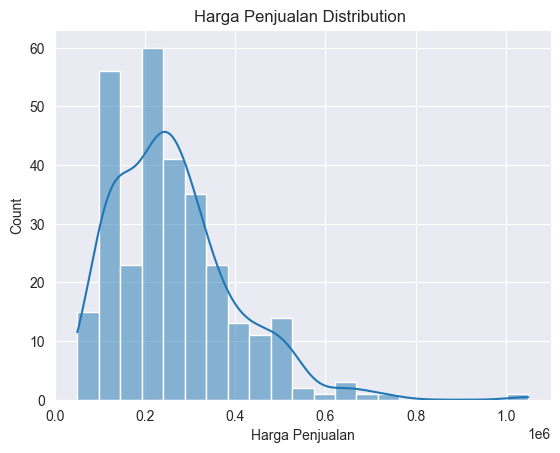

In [8]:
# check `Harga Penjualan` distribution
sns.histplot(data['Harga Penjualan'], kde=True)
plt.title('Harga Penjualan Distribution ')
plt.show()

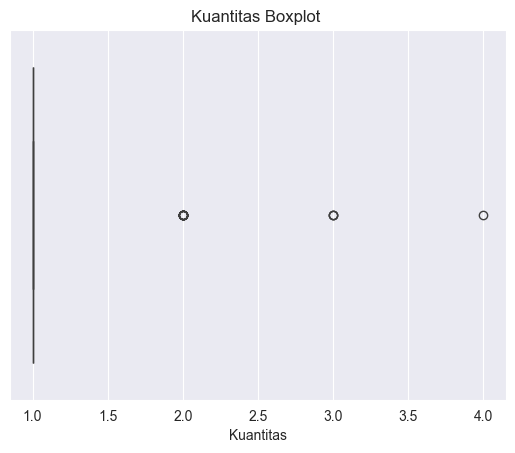

In [9]:
# check `Kuantitas` boxplot
sns.boxplot(x=data['Kuantitas'])
plt.title('Kuantitas Boxplot ')
plt.show()

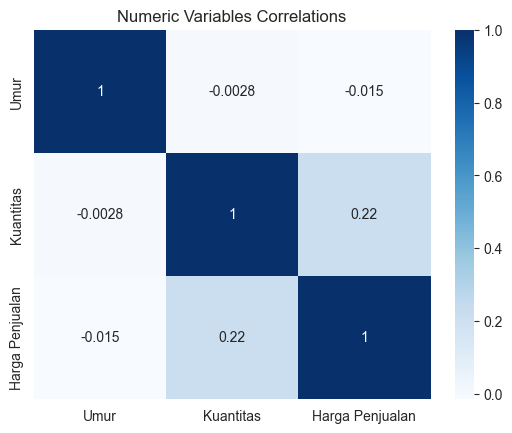

In [10]:
# numveric variables correlations
corr_matrix = data[['Umur', 'Kuantitas', 'Harga Penjualan']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.title('Numeric Variables Correlations')
plt.show()

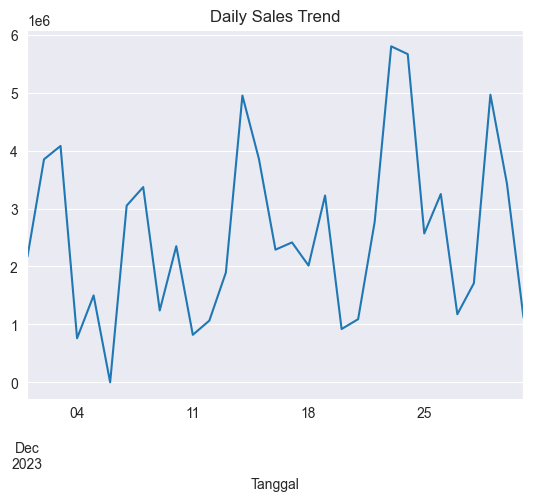

In [11]:
# sales trend by `Tanggal`
data['Tanggal'] = pd.to_datetime(data['Tanggal'])
data.set_index('Tanggal').resample('D')['Harga Penjualan'].sum().plot()
plt.title('Daily Sales Trend')
plt.show()

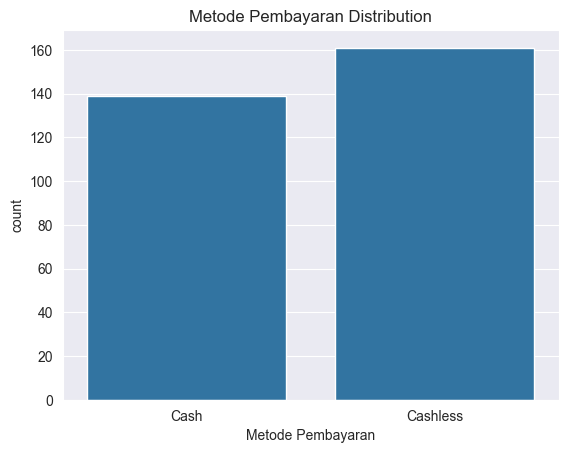

In [12]:
# `Metode Pembayaran` distribution
sns.countplot(x='Metode Pembayaran', data=data)
plt.title('Metode Pembayaran Distribution')
plt.show()

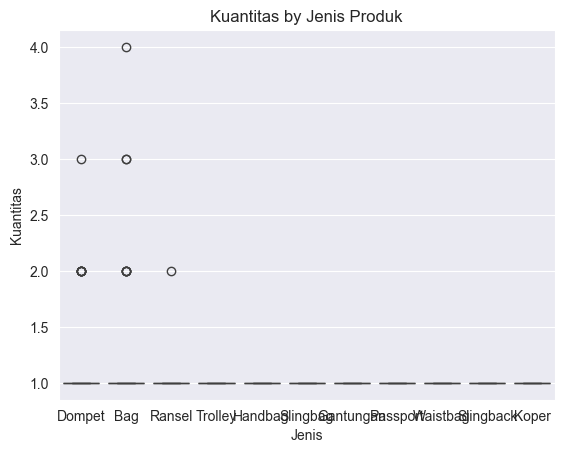

In [13]:
# Correlation between `Jenis Produk` dan `Kuantitas`
sns.boxplot(x='Jenis', y='Kuantitas', data=data)
plt.title('Kuantitas by Jenis Produk')
plt.show()

## Data Cleaning

In [14]:
# concatenate `Nama` and `Jenis` column first
data['Nama'] = data['Jenis'] + ' ' + data['Nama']

# delete `Jenis` column
data = data.drop(['Jenis'], axis=1)

# delete `Nomor` and `Harga Penjualan` columns
data = data.drop(['Nomor', 'Harga Penjualan'], axis=1)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Umur               300 non-null    int64         
 1   Tanggal            300 non-null    datetime64[ns]
 2   Hari               300 non-null    object        
 3   Nama               300 non-null    object        
 4   Kode               300 non-null    object        
 5   Kuantitas          300 non-null    int64         
 6   Unit               300 non-null    object        
 7   Metode Pembayaran  300 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 18.9+ KB


In [15]:
# drop null values
data.dropna(inplace=True)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Umur               300 non-null    int64         
 1   Tanggal            300 non-null    datetime64[ns]
 2   Hari               300 non-null    object        
 3   Nama               300 non-null    object        
 4   Kode               300 non-null    object        
 5   Kuantitas          300 non-null    int64         
 6   Unit               300 non-null    object        
 7   Metode Pembayaran  300 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 18.9+ KB


In [17]:
# check duplicated data
data.duplicated().sum()

0

### Data normalization

In [18]:
# transform `Tanggal` column into datetime
data['Tanggal'] = pd.to_datetime(data['Tanggal'])
data['Tanggal'] = (data['Tanggal'] - data['Tanggal'].min()).dt.days
data.head()

,Umur,Tanggal,Hari,Nama,Kode,Kuantitas,Unit,Metode Pembayaran
0,50,0,Friday,Dompet Kartu,63203,1,pcs,Cash
1,20,0,Friday,Bag Gyd,6935,2,pcs,Cashless
2,49,0,Friday,Bag LV,2408,1,pcs,Cashless
3,40,0,Friday,Bag YSL,4,1,pcs,Cash
4,48,0,Friday,Dompet Kartu,GC,1,pcs,Cash


In [19]:
le = {}

# initiate label encoder
for column in ['Hari', 'Nama', 'Kode', 'Unit', 'Metode Pembayaran']:
    le[column] = LabelEncoder()

# transform categorical columns with label encoder
for column in ['Hari', 'Nama', 'Kode', 'Unit', 'Metode Pembayaran']:
    data[column] = le[column].fit_transform(data[column].astype(str))

data.head()

,Umur,Tanggal,Hari,Nama,Kode,Kuantitas,Unit,Metode Pembayaran
0,50,0,0,39,115,1,0,0
1,20,0,0,12,128,2,0,1
2,49,0,0,19,47,1,0,1
3,40,0,0,27,84,1,0,0
4,48,0,0,39,200,1,0,0


In [20]:
# transform numerical column with min max scaler
umur_scaler = MinMaxScaler()
kuantitas_scaler = MinMaxScaler()
data['Umur'] = umur_scaler.fit_transform(data['Umur'].values.reshape(-1, 1))
data['Kuantitas'] = kuantitas_scaler.fit_transform(data['Kuantitas'].values.reshape(-1, 1))

data.head()

,Umur,Tanggal,Hari,Nama,Kode,Kuantitas,Unit,Metode Pembayaran
0,1.000000,0,0,39,115,0.000000,0,0
1,0.000000,0,0,12,128,0.333333,0,1
2,0.966667,0,0,19,47,0.000000,0,1
3,0.666667,0,0,27,84,0.000000,0,0
4,0.933333,0,0,39,200,0.000000,0,0


In [21]:
# dump encoders and scalers
dump(le, 'encoders/le_encoders.pkl')
dump(umur_scaler, 'scalers/umur_scaler.pkl')
dump(kuantitas_scaler, 'scalers/kuantitas_scaler.pkl')

['scalers/kuantitas_scaler.pkl']

### Split X and Y data

In [22]:
# drop `Kuantitas` predict from X
X = data.drop(['Kuantitas'], axis=1)

# assign `Kuantitas` into y
y = data['Kuantitas']

In [23]:
X

,Umur,Tanggal,Hari,Nama,Kode,Unit,Metode Pembayaran
0,1.000000,0,0,39,115,0,0
1,0.000000,0,0,12,128,0,1
2,0.966667,0,0,19,47,0,1
3,0.666667,0,0,27,84,0,0
4,0.933333,0,0,39,200,0,0
...,...,...,...,...,...,...,...
295,0.766667,30,3,75,124,0,1
296,0.266667,30,3,45,130,0,1
297,0.033333,30,3,36,164,0,1
298,0.800000,30,3,17,12,0,0


In [24]:
y

0      0.000000
1      0.333333
2      0.000000
3      0.000000
4      0.000000
         ...   
295    0.000000
296    0.000000
297    0.000000
298    0.333333
299    0.000000
Name: Kuantitas, Length: 300, dtype: float64

In [25]:
# split the train and test data (70:30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'X_train data length: {len(X_train)}')
print(f'X_test data length: {len(X_test)}')
print(f'y_train data length: {len(y_train)}')
print(f'y_test data length: {len(y_test)}')
n_samples_train, n_features_train = X_train.shape
n_samples_train, n_features_train

X_train data length: 240
X_test data length: 60
y_train data length: 240
y_test data length: 60


(240, 7)

# **Model Training**

In [26]:
# func for get adjusted_r2
def adjusted_r_squared(y_test, y_pred, n_samples, n_features):
    r_squared = r2_score(y_test, y_pred)
    adjusted_r_squared = 1 - (1 - r_squared) * (n_samples - 1) / (n_samples - n_features - 1)
    return adjusted_r_squared

# n_samples and n_features for the train set
n_samples_train, n_features_train = X_train.shape

# n_samples and n_features for the test set
n_samples_test, n_features_test = X_test.shape

## Linear Regression

In [27]:
# initialize
lr = LinearRegression()

# train the model
lr.fit(X_train, y_train)

LinearRegression()

In [28]:
# Linear Regression predict
lr_y_pred_train = lr.predict(X_train)

# evaluate
lr_y_pred_train_mse = mean_squared_error(y_train, lr_y_pred_train)
lr_y_pred_train_mae = mean_absolute_error(y_train, lr_y_pred_train)
lr_y_pred_train_r2 = r2_score(y_train, lr_y_pred_train)
lr_y_pred_train_adjusted_r2 = adjusted_r_squared(y_train, lr_y_pred_train, n_samples_train, n_features_train)

# print
print("Linear Regression Evaluation Metrics")
print(f"Mean Squared Error (MSE):   {lr_y_pred_train_mse:.3f}")
print(f"Mean Absolute Error (MAE):  {lr_y_pred_train_mae:.3f}")
print(f"R-squared Score (R2):       {lr_y_pred_train_r2:.3f}")
print(f"Adjusted R-squared Score:   {lr_y_pred_train_adjusted_r2:.3f}")

Linear Regression Evaluation Metrics
Mean Squared Error (MSE):   0.011
Mean Absolute Error (MAE):  0.042
R-squared Score (R2):       0.023
Adjusted R-squared Score:   -0.007


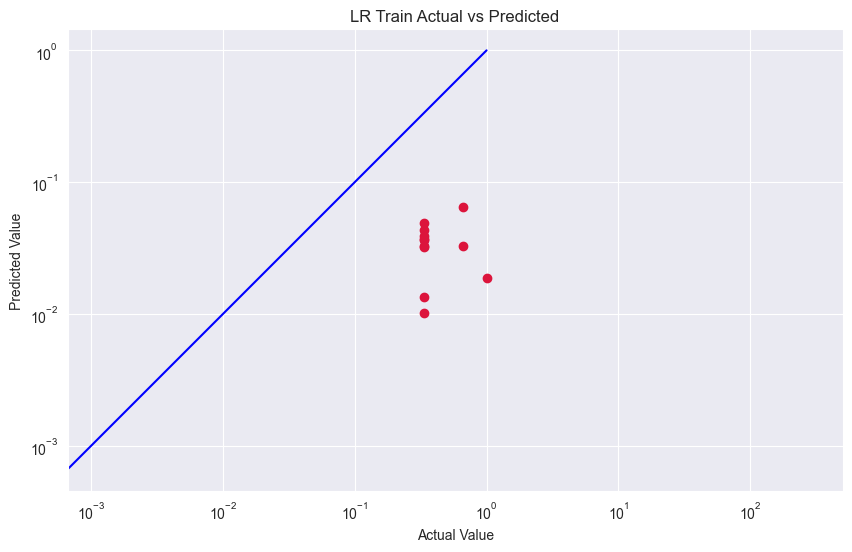

In [29]:
# plot actual vs predicted 
plt.figure(figsize=(10, 6))
plt.scatter(y_train, lr_y_pred_train, c='crimson')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('LR Train Actual vs Predicted')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'b-')
plt.axis('equal')
plt.show()

## XGB Regression

In [30]:
# initialize
xgb = XGBRegressor()

# train the model
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [31]:
# XGB Regression predict
xgb_y_pred_train = xgb.predict(X_train)

# evaluate
xgb_y_pred_train_mse = mean_squared_error(y_train, xgb_y_pred_train)
xgb_y_pred_train_mae = mean_absolute_error(y_train, xgb_y_pred_train)
xgb_y_pred_train_r2 = r2_score(y_train, xgb_y_pred_train)
xgb_y_pred_train_adjusted_r2 = adjusted_r_squared(y_train, xgb_y_pred_train, n_samples_train, n_features_train)

# print
print("XGB Regression Evaluation Metrics")
print(f"Mean Squared Error (MSE):   {xgb_y_pred_train_mse:.3f}")
print(f"Mean Absolute Error (MAE):  {xgb_y_pred_train_mae:.3f}")
print(f"R-squared Score (R2):       {xgb_y_pred_train_r2:.3f}")
print(f"Adjusted R-squared Score:   {xgb_y_pred_train_adjusted_r2:.3f}")

XGB Regression Evaluation Metrics
Mean Squared Error (MSE):   0.000
Mean Absolute Error (MAE):  0.001
R-squared Score (R2):       1.000
Adjusted R-squared Score:   1.000


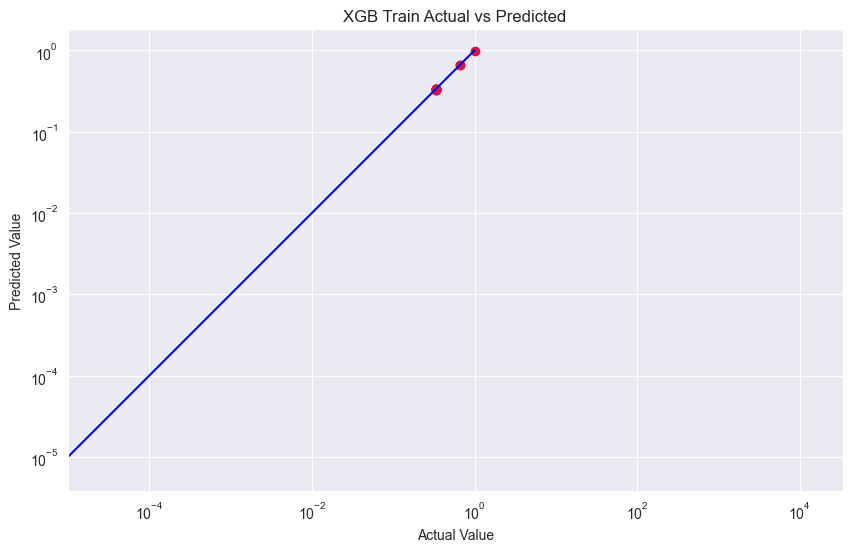

In [32]:
# plot actual vs predicted 
plt.figure(figsize=(10, 6))
plt.scatter(y_train, xgb_y_pred_train, c='crimson')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('XGB Train Actual vs Predicted')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'b-')
plt.axis('equal')
plt.show()

## Random Forest Regression

In [33]:
# initialize
rf = RandomForestRegressor(n_estimators=100, random_state=100)

# train the model
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=100)

In [34]:
# XGB Regression predict
rf_y_pred_train = rf.predict(X_train)

# evaluate
rf_y_pred_train_mse = mean_squared_error(y_train, rf_y_pred_train)
rf_y_pred_train_mae = mean_absolute_error(y_train, rf_y_pred_train)
rf_y_pred_train_r2 = r2_score(y_train, rf_y_pred_train)
rf_y_pred_train_adjusted_r2 = adjusted_r_squared(y_train, rf_y_pred_train, n_samples_train, n_features_train)

# print
print("Random Forest Regression Evaluation Metrics")
print(f"Mean Squared Error (MSE):   {rf_y_pred_train_mse:.3f}")
print(f"Mean Absolute Error (MAE):  {rf_y_pred_train_mae:.3f}")
print(f"R-squared Score (R2):       {rf_y_pred_train_r2:.3f}")
print(f"Adjusted R-squared Score:   {rf_y_pred_train_adjusted_r2:.3f}")

Random Forest Regression Evaluation Metrics
Mean Squared Error (MSE):   0.002
Mean Absolute Error (MAE):  0.019
R-squared Score (R2):       0.821
Adjusted R-squared Score:   0.815


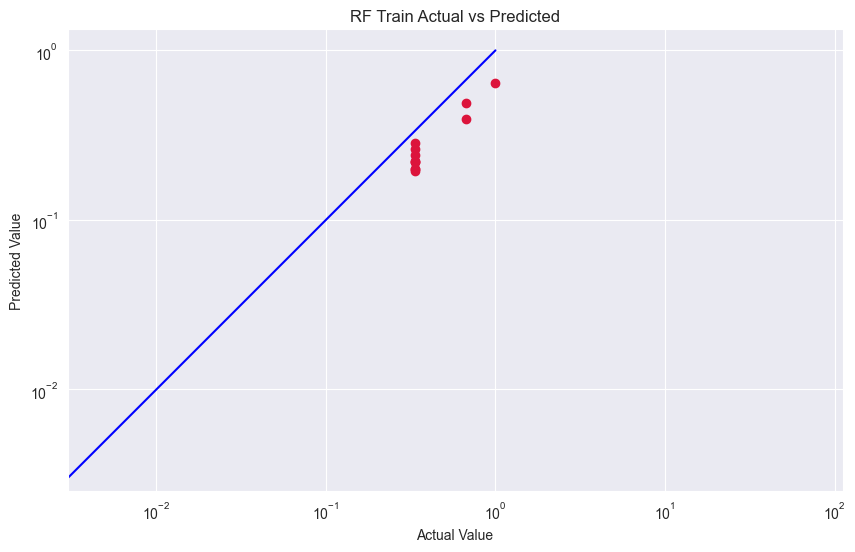

In [35]:
# plot actual vs predicted 
plt.figure(figsize=(10, 6))
plt.scatter(y_train, rf_y_pred_train, c='crimson')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('RF Train Actual vs Predicted')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'b-')
plt.axis('equal')
plt.show()

## GBR Regression

In [36]:
# initialize
gbr = GradientBoostingRegressor()

# train the model
gbr.fit(X_train, y_train)

GradientBoostingRegressor()

In [37]:
# GBR Regression predict
gbr_y_pred_train = gbr.predict(X_train)

# evaluate
gbr_y_pred_train_mse = mean_squared_error(y_train, gbr_y_pred_train)
gbr_y_pred_train_mae = mean_absolute_error(y_train, gbr_y_pred_train)
gbr_y_pred_train_r2 = r2_score(y_train, gbr_y_pred_train)
gbr_y_pred_train_adjusted_r2 = adjusted_r_squared(y_train, gbr_y_pred_train, n_samples_train, n_features_train)

# print
print("GBR Regression Evaluation Metrics")
print(f"Mean Squared Error (MSE):   {gbr_y_pred_train_mse:.3f}")
print(f"Mean Absolute Error (MAE):  {gbr_y_pred_train_mae:.3f}")
print(f"R-squared Score (R2):       {gbr_y_pred_train_r2:.3f}")
print(f"Adjusted R-squared Score:   {gbr_y_pred_train_adjusted_r2:.3f}")

GBR Regression Evaluation Metrics
Mean Squared Error (MSE):   0.002
Mean Absolute Error (MAE):  0.019
R-squared Score (R2):       0.869
Adjusted R-squared Score:   0.865


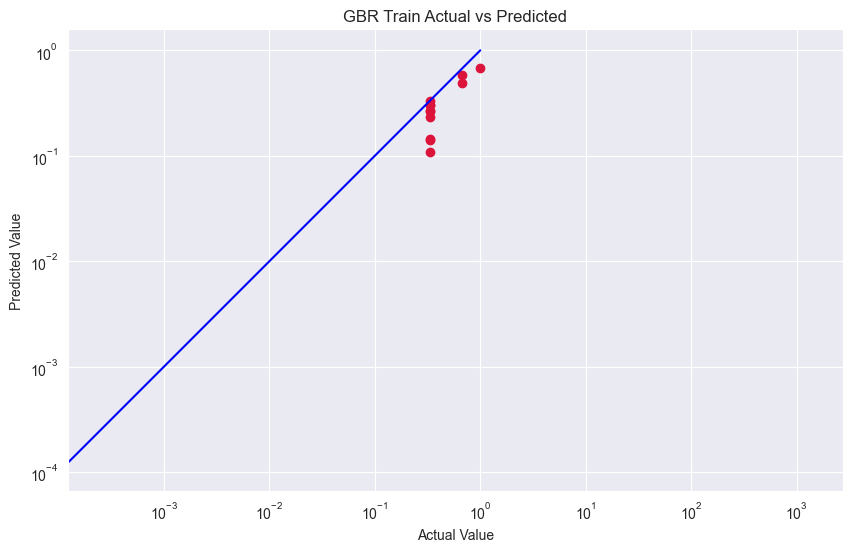

In [38]:
# plot actual vs predicted 
plt.figure(figsize=(10, 6))
plt.scatter(y_train, gbr_y_pred_train, c='crimson')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('GBR Train Actual vs Predicted')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'b-')
plt.axis('equal')
plt.show()

## SVM Regression

In [39]:
# initialize
svr = SVR()

# train the model
svr.fit(X_train, y_train)

SVR()

In [40]:
# SVM Regression predict
svm_y_pred_train = svr.predict(X_train)

# evaluate
svm_y_pred_train_mse = mean_squared_error(y_train, svm_y_pred_train)
svm_y_pred_train_mae = mean_absolute_error(y_train, svm_y_pred_train)
svm_y_pred_train_r2 = r2_score(y_train, svm_y_pred_train)
svm_y_pred_train_adjusted_r2 = adjusted_r_squared(y_train, svm_y_pred_train, n_samples_train, n_features_train)

# print
print("SVM Regression Evaluation Metrics")
print(f"Mean Squared Error (MSE):   {svm_y_pred_train_mse:.3f}")
print(f"Mean Absolute Error (MAE):  {svm_y_pred_train_mae:.3f}")
print(f"R-squared Score (R2):       {svm_y_pred_train_r2:.3f}")
print(f"Adjusted R-squared Score:   {svm_y_pred_train_adjusted_r2:.3f}")

SVM Regression Evaluation Metrics
Mean Squared Error (MSE):   0.018
Mean Absolute Error (MAE):  0.112
R-squared Score (R2):       -0.520
Adjusted R-squared Score:   -0.566


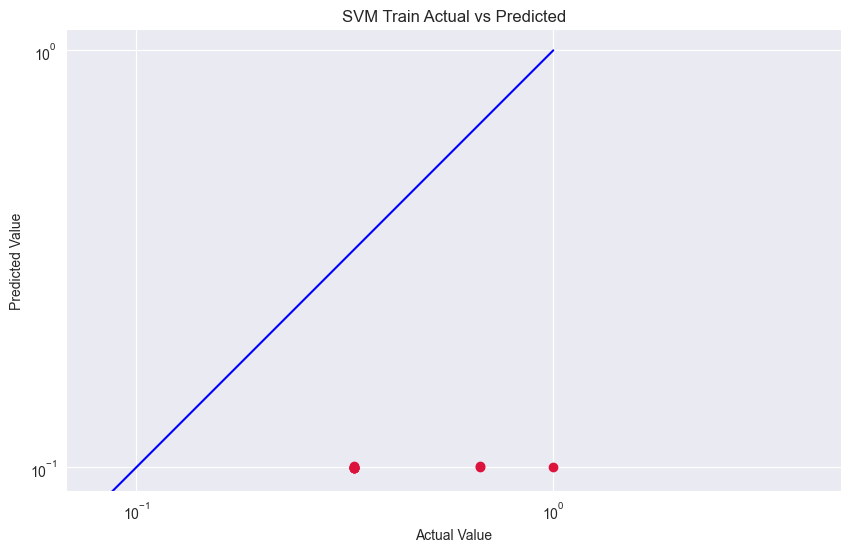

In [41]:
# plot actual vs predicted 
plt.figure(figsize=(10, 6))
plt.scatter(y_train, svm_y_pred_train, c='crimson')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('SVM Train Actual vs Predicted')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'b-')
plt.axis('equal')
plt.show()

# **Save The Trained Model**

In [42]:
# save all the models
dump(lr, 'models/LinearRegression.joblib')
dump(xgb, 'models/XGBRegression.joblib')
dump(rf, 'models/RandomForestRegression.joblib')
dump(gbr, 'models/GBRRegression.joblib')
dump(svr, 'models/SVRRegression.joblib')

['models/SVRRegression.joblib']

# **Test The Models with Testing Data**

## Linear Regression

In [43]:
#  load the saved model
lr_loaded = load('models/LinearRegression.joblib')

In [44]:
# predict
lr_y_pred_test = lr_loaded.predict(X_test)

# evaluate
lr_y_pred_test_mse = mean_squared_error(y_test, lr_y_pred_test)
lr_y_pred_test_mae = mean_absolute_error(y_test, lr_y_pred_test)
lr_y_pred_test_r2 = r2_score(y_test, lr_y_pred_test)
lr_y_pred_test_adjusted_r2 = adjusted_r_squared(y_test, lr_y_pred_test, n_samples_test, n_features_test)

# print
print("Linear Regression Test Evaluation Metrics")
print(f"Mean Squared Error (MSE):   {lr_y_pred_test_mse:.3f}")
print(f"Mean Absolute Error (MAE):  {lr_y_pred_test_mae:.3f}")
print(f"R-squared Score (R2):       {lr_y_pred_test_r2:.3f}")
print(f"Adjusted R-squared Score:   {lr_y_pred_test_adjusted_r2:.3f}")

Linear Regression Test Evaluation Metrics
Mean Squared Error (MSE):   0.014
Mean Absolute Error (MAE):  0.051
R-squared Score (R2):       -0.018
Adjusted R-squared Score:   -0.156


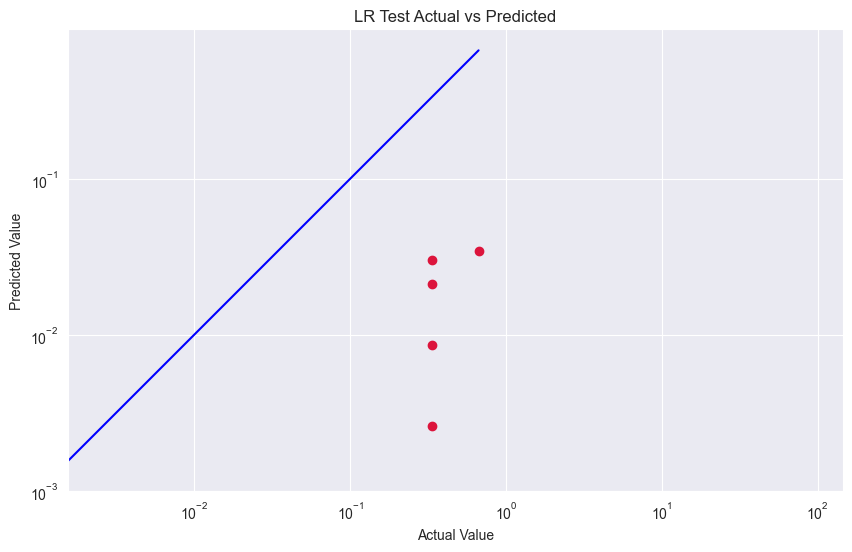

In [45]:
# plot actual vs predicted 
plt.figure(figsize=(10, 6))
plt.scatter(y_test, lr_y_pred_test, c='crimson')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('LR Test Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'b-')
plt.axis('equal')
plt.show()

## XGB Regression

In [46]:
#  load the saved model
xgb_loaded = load('models/XGBRegression.joblib')

In [47]:
# predict
xgb_y_pred_test = xgb_loaded.predict(X_test)

# evaluate
xgb_y_pred_test_mse = mean_squared_error(y_test, xgb_y_pred_test)
xgb_y_pred_test_mae = mean_absolute_error(y_test, xgb_y_pred_test)
xgb_y_pred_test_r2 = r2_score(y_test, xgb_y_pred_test)
xgb_y_pred_test_adjusted_r2 = adjusted_r_squared(y_test, xgb_y_pred_test, n_samples_test, n_features_test)

# print
print("XGB Regression Test Evaluation Metrics")
print(f"Mean Squared Error (MSE):   {xgb_y_pred_test_mse:.3f}")
print(f"Mean Absolute Error (MAE):  {xgb_y_pred_test_mae:.3f}")
print(f"R-squared Score (R2):       {xgb_y_pred_test_r2:.3f}")
print(f"Adjusted R-squared Score:   {xgb_y_pred_test_adjusted_r2:.3f}")

XGB Regression Test Evaluation Metrics
Mean Squared Error (MSE):   0.021
Mean Absolute Error (MAE):  0.060
R-squared Score (R2):       -0.508
Adjusted R-squared Score:   -0.711


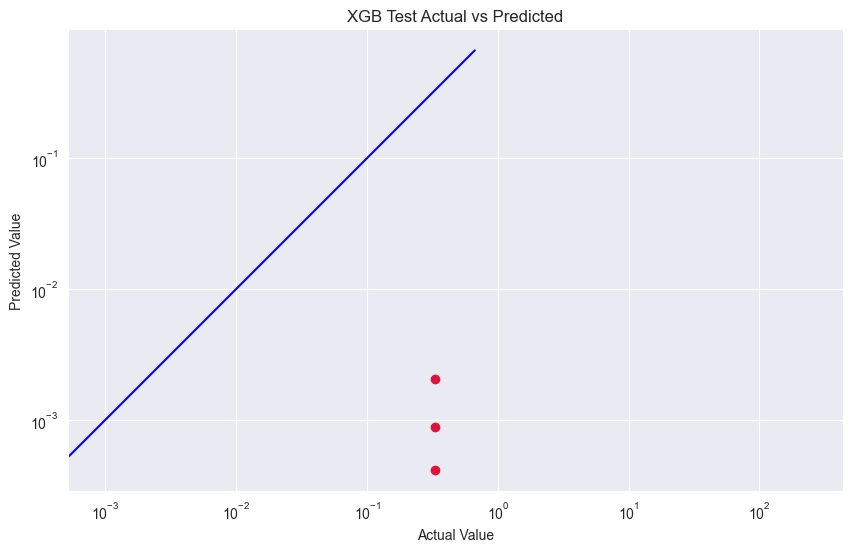

In [48]:
# plot actual vs predicted 
plt.figure(figsize=(10, 6))
plt.scatter(y_test, xgb_y_pred_test, c='crimson')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('XGB Test Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'b-')
plt.axis('equal')
plt.show()

## Random Forest Regression

In [49]:
#  load the saved model
rf_loaded = load('models/RandomForestRegression.joblib')

In [50]:
# predict
rf_y_pred_test = rf_loaded.predict(X_test)

# evaluate
rf_y_pred_test_mse = mean_squared_error(y_test, rf_y_pred_test)
rf_y_pred_test_mae = mean_absolute_error(y_test, rf_y_pred_test)
rf_y_pred_test_r2 = r2_score(y_test, rf_y_pred_test)
rf_y_pred_test_adjusted_r2 = adjusted_r_squared(y_test, rf_y_pred_test, n_samples_test, n_features_test)

# print
print("Random Forest Regression Test Evaluation Metrics")
print(f"Mean Squared Error (MSE):   {rf_y_pred_test_mse:.3f}")
print(f"Mean Absolute Error (MAE):  {rf_y_pred_test_mae:.3f}")
print(f"R-squared Score (R2):       {rf_y_pred_test_r2:.3f}")
print(f"Adjusted R-squared Score:   {rf_y_pred_test_adjusted_r2:.3f}")

Random Forest Regression Test Evaluation Metrics
Mean Squared Error (MSE):   0.020
Mean Absolute Error (MAE):  0.060
R-squared Score (R2):       -0.462
Adjusted R-squared Score:   -0.658


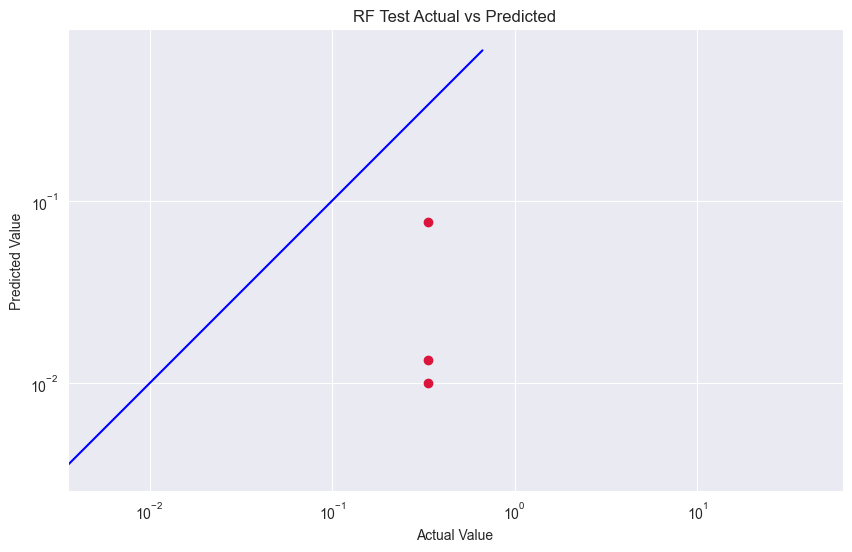

In [51]:
# plot actual vs predicted 
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_y_pred_test, c='crimson')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('RF Test Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'b-')
plt.axis('equal')
plt.show()

## GBR Regression

In [52]:
#  load the saved model
gbr_loaded = load('models/GBRRegression.joblib')

In [53]:
# predict
gbr_y_pred_test = gbr_loaded.predict(X_test)

# evaluate
gbr_y_pred_test_mse = mean_squared_error(y_test, gbr_y_pred_test)
gbr_y_pred_test_mae = mean_absolute_error(y_test, gbr_y_pred_test)
gbr_y_pred_test_r2 = r2_score(y_test, gbr_y_pred_test)
gbr_y_pred_test_adjusted_r2 = adjusted_r_squared(y_test, gbr_y_pred_test, n_samples_test, n_features_test)

# print
print("GBR Regression Test Evaluation Metrics")
print(f"Mean Squared Error (MSE):   {gbr_y_pred_test_mse:.3f}")
print(f"Mean Absolute Error (MAE):  {gbr_y_pred_test_mae:.3f}")
print(f"R-squared Score (R2):       {gbr_y_pred_test_r2:.3f}")
print(f"Adjusted R-squared Score:   {gbr_y_pred_test_adjusted_r2:.3f}")

GBR Regression Test Evaluation Metrics
Mean Squared Error (MSE):   0.026
Mean Absolute Error (MAE):  0.074
R-squared Score (R2):       -0.903
Adjusted R-squared Score:   -1.159


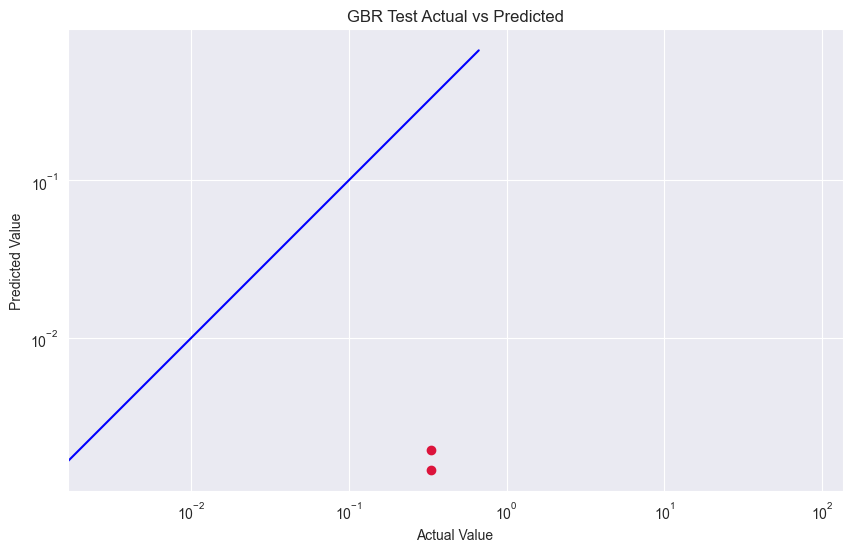

In [54]:
# plot actual vs predicted 
plt.figure(figsize=(10, 6))
plt.scatter(y_test, gbr_y_pred_test, c='crimson')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('GBR Test Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'b-')
plt.axis('equal')
plt.show()

## SVR Regression

In [55]:
#  load the saved model
svr_loaded = load('models/SVRRegression.joblib')

In [56]:
# predict
svr_y_pred_test = svr_loaded.predict(X_test)

# evaluate
svr_y_pred_test_mse = mean_squared_error(y_test, svr_y_pred_test)
svr_y_pred_test_mae = mean_absolute_error(y_test, svr_y_pred_test)
svr_y_pred_test_r2 = r2_score(y_test, svr_y_pred_test)
svr_y_pred_test_adjusted_r2 = adjusted_r_squared(y_test, svr_y_pred_test, n_samples_test, n_features_test)

# print
print("SVR Regression Test Evaluation Metrics")
print(f"Mean Squared Error (MSE):   {svr_y_pred_test_mse:.3f}")
print(f"Mean Absolute Error (MAE):  {svr_y_pred_test_mae:.3f}")
print(f"R-squared Score (R2):       {svr_y_pred_test_r2:.3f}")
print(f"Adjusted R-squared Score:   {svr_y_pred_test_adjusted_r2:.3f}")

SVR Regression Test Evaluation Metrics
Mean Squared Error (MSE):   0.018
Mean Absolute Error (MAE):  0.116
R-squared Score (R2):       -0.322
Adjusted R-squared Score:   -0.500


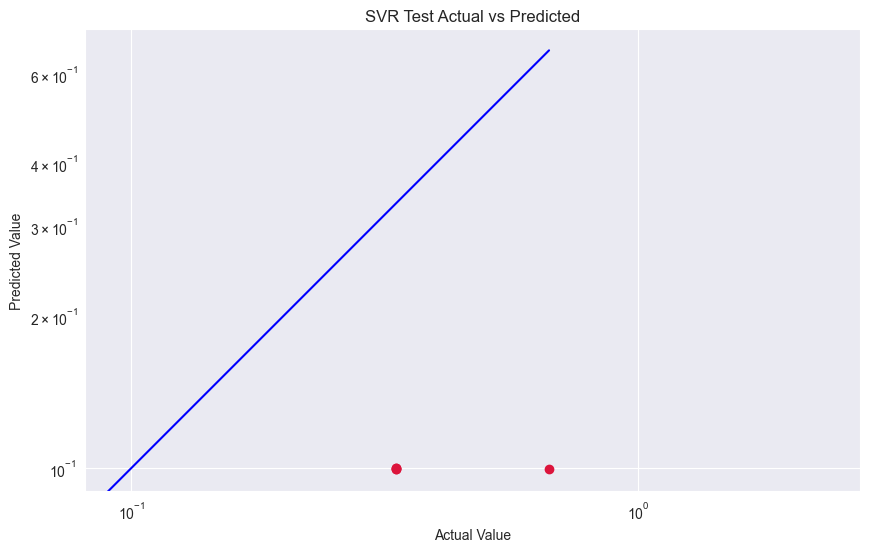

In [57]:
# plot actual vs predicted 
plt.figure(figsize=(10, 6))
plt.scatter(y_test, svr_y_pred_test, c='crimson')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('SVR Test Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'b-')
plt.axis('equal')
plt.show()

# **Create Function For Predict Using Chosen Models**

In [60]:
from datetime import datetime
def predict(nama, umur, kode, metode_pembayaran, tanggal, unit):

    # get day by date
    date_object = datetime.strptime(tanggal, "%m/%d/%Y")
    hari = date_object.strftime("%A")

    data = {
        'Umur': [umur],
        'Tanggal': [tanggal],
        'Hari': [hari],
        'Nama': [nama],
        'Kode': [kode],
        'Unit': [unit],
        'Metode Pembayaran': [metode_pembayaran],
    }

    df = pd.DataFrame(data)

    le_loaded = load('encoders/le_encoders.pkl')
    umur_scaler_loaded = load('scalers/umur_scaler.pkl')
    kuantitas_scaler_loaded = load('scalers/kuantitas_scaler.pkl')

    # check `unseen labels`
    def transform_label(column, value):
        if value in le_loaded[column].classes_:
            return le_loaded[column].transform([value])[0]
        else:
            raise ValueError(f"Unseen label '{value}' encountered in column '{column}'")
            # return -1

    for column in ['Hari', 'Nama', 'Kode', 'Unit', 'Metode Pembayaran']:
        df[column] = df[column].apply(lambda x: transform_label(column, x))

    df['Tanggal'] = pd.to_datetime(df['Tanggal'])
    df['Tanggal'] = (df['Tanggal'] - df['Tanggal'].min()).dt.days

    df['Umur'] = umur_scaler_loaded.transform(df['Umur'].values.reshape(-1, 1))

    rf_loaded_model = load('models/RandomForestRegression.joblib')
    rf_loaded_pred_scaled = rf_loaded_model.predict(df)
    rf_loaded_pred = kuantitas_scaler_loaded.inverse_transform(rf_loaded_pred_scaled.reshape(-1,1))
    return int(round(rf_loaded_pred[0][0],0))

In [61]:
name = 'Bag Fashion'
age = 47
code = '2930'
payment_method = 'Cashless'
date = '12/3/2023'
unit = 'pcs'

test_qty_pred = predict(name, age, code, payment_method, date, unit)
print(f"Prediction purchase quantity: {test_qty_pred} {unit}")

Prediction purchase quantity: 1 pcs
